Imports

In [48]:
import sklearn as sk;
import pandas as pd;
import os;
from google.colab import files;
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
from google.colab import drive
# for mounting google drive to access training data from
# filepath: /content/drive/MyDrive/Colab Notebooks
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data cleaning

In [50]:
# importing data into dataframes
not_loaded = True
while not_loaded:
    try:
        if "churn_train.csv" in os.listdir():
            churn_train = pd.read_csv("customer_churn_dataset-training-master.csv")
            churn_test = pd.read_csv("customer_churn_dataset-testing-master.csv")
            not_loaded = False
        else:
            churn_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer_churn_dataset-training-master.csv")
            churn_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer_churn_dataset-testing-master.csv")
            not_loaded = False
    except FileNotFoundError as e:
        files.upload()

In [51]:
churn_train.head()
gender = {"Female":0, "Male":1}
Sub_type = {"Standard":0, "Basic":1}
Con_len = {"Annual":0, "Monthly":1}

# converted df
conv_churn_train = churn_train.copy()
conv_churn_train["Gender"] = conv_churn_train["Gender"].map(gender).fillna(2)
conv_churn_train["Subscription Type"] = conv_churn_train["Subscription Type"].map(Sub_type).fillna(2)
conv_churn_train["Contract Length"] = conv_churn_train["Contract Length"].map(Con_len).fillna(2)


In [52]:
missing = conv_churn_train.isnull().any(axis=0).sum()
total = len(churn_train.index)
# print((missing / total)*100)
# 0.002% columns are null! There are 9 records that are empty.
# Because the missing data takes up a small portion of the training data I will be employing kNNImputer as I can afford the computation overhead

imputer = sk.impute.KNNImputer(n_neighbors=2)
clean_churn_train = pd.DataFrame(imputer.fit_transform(conv_churn_train))
clean_churn_train.columns = conv_churn_train.columns
filled = clean_churn_train.isnull().any(axis=0).sum()
print(f"number of rows with nan:{missing}\nnumber of rows with nan after cleaning:{filled}")

number of rows with nan:9
number of rows with nan after cleaning:0


Pre-processing

In [53]:
clean_churn_train["Last Interaction zscore"] = (
    (clean_churn_train["Last Interaction"] - clean_churn_train["Last Interaction"].mean())/clean_churn_train["Last Interaction"].std()
)
variance = clean_churn_train['Last Interaction zscore'].std() ** 2
mean = clean_churn_train['Last Interaction zscore'].mean()
print(f"var{variance:.2e}, mean{mean:.2e}\nApproximately 1 and 0")

var1.00e+00, mean1.28e-16
Approximately 1 and 0


In [54]:
# Calculate percentiles for 'Total Spend'
percentiles = clean_churn_train['Total Spend'].quantile([0.00, 0.20, 0.40, 0.60, 0.80, 1.00])
bins = percentiles.tolist()

clean_churn_train['Total Spend'] = pd.cut(clean_churn_train['Total Spend'], bins=bins, labels=[0.20, 0.40, 0.60, 0.80, 1.00])


In [55]:
print("Number of rows for each 'Total Spend' quantile:")
print(clean_churn_train['Total Spend'].value_counts().sort_index())

Number of rows for each 'Total Spend' quantile:
Total Spend
0.2    88248
0.4    87985
0.6    88170
0.8    88167
1.0    88163
Name: count, dtype: int64


In [56]:
cat_encoder = sk.preprocessing.OneHotEncoder()
clean_churn_train_OneHot = cat_encoder.fit_transform(clean_churn_train[['Contract Length']])
print(clean_churn_train_OneHot[:5])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5 stored elements and shape (5, 3)>
  Coords	Values
  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 1)	1.0
  (4, 1)	1.0


In [58]:
# creating new attributes
# choosing average spending (total_spending/tenure)
# Convert 'Total Spend' from categorical to numeric before division
test_churn_train = clean_churn_train.copy()

test_churn_train['Total Spend'] = test_churn_train['Total Spend'].astype(float)
test_churn_train['Average Spending'] = test_churn_train['Total Spend'] / test_churn_train['Tenure']

In [59]:
correlation_matrix = clean_churn_train.corr()
# display(correlation_matrix)

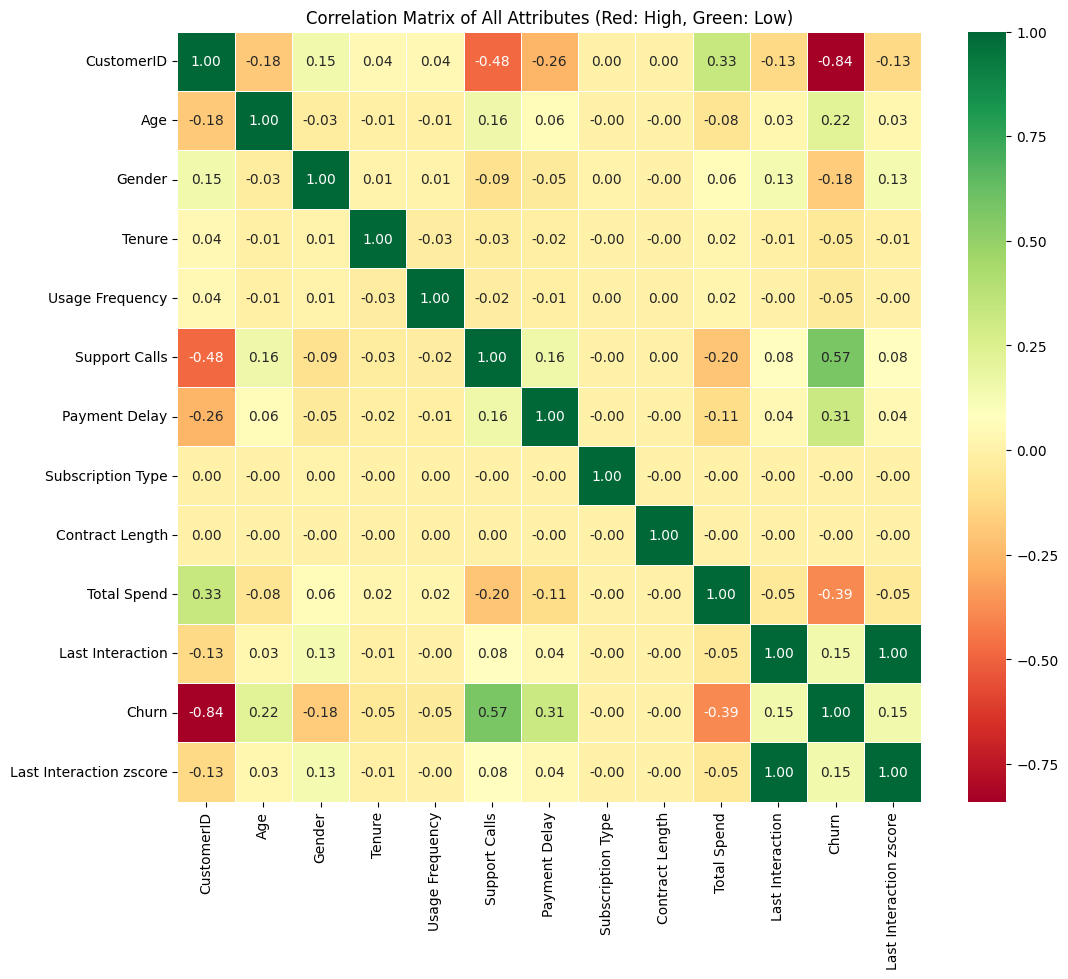

In [60]:
plt.figure(figsize=(12, 10)) # Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of All Attributes (Red: High, Green: Low)')
plt.show()

In [ ]:
clean_churn_train